<h1>Gating Experiments: FMO KNN</h1>

In [1]:
from immunova.data.project import Project
from immunova.data.mongo_setup import global_init
from immunova.flow.gating.actions import Template, Gating
from tqdm import tqdm_notebook, tqdm
from functools import partial
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
global_init()

In [2]:
iltis = Project.objects(project_id='ILTIS').get()

<h2>Create some populations using the T Panel</h2>

In [3]:
iltis.list_fcs_experiments()

['t1_exp', 't2_exp', 'n_exp']

In [28]:
t1_exp = iltis.load_experiment('t1_exp')

In [777]:
t_template = Template(experiment=t1_exp, sample_id='sep68')

In [778]:
t_template.gates = dict()

In [779]:
x = t_template.remove_population('cells')

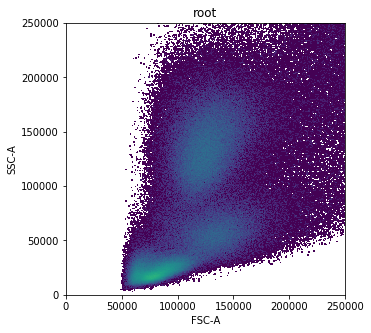

In [780]:
_ = t_template.plot_population('root', x='FSC-A', y='SSC-A')

<h3>Boundary gate</h3>

In [781]:
kwargs=dict(x_min=50000, x_max=150000, y_min=0, y_max=50000)
child_populations = dict(cells=dict(definition='+'))
t_template.create_gate(gate_name='cells', parent='root', x='FSC-A', y='SSC-A', 
                       func='rect_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

True

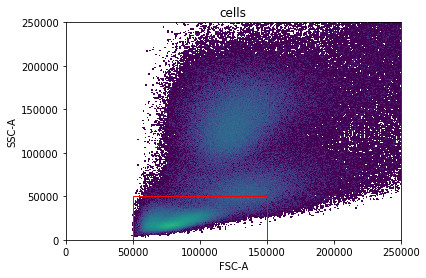

In [782]:
t_template.apply('cells')

<h3>Lymphocyte gate</h3>

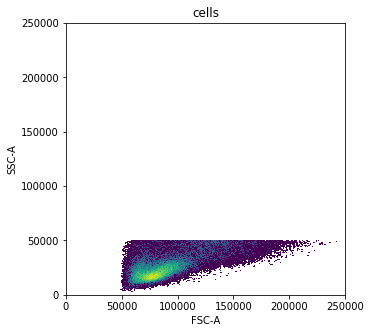

In [783]:
_ = t_template.plot_population('cells', x='FSC-A', y='SSC-A')

In [784]:
kwargs=dict(target=(50000,50000), k=3, conf=0.99)
child_populations = dict(lymphocytes=dict(definition='+'))
t_template.create_gate(gate_name='lymphocytes', parent='cells',x='FSC-A', 
                       y='SSC-A', func='mm_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

True

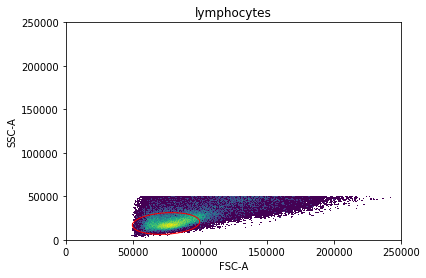

In [785]:
t_template.apply('lymphocytes')

<h3>Singlet gate</h3>

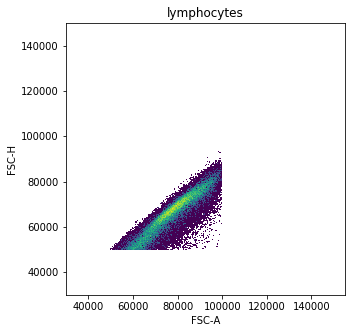

In [786]:
_ = t_template.plot_population('lymphocytes', x='FSC-A', y='FSC-H', xlim=(30000,155000), ylim=(30000,150000))

In [787]:
kwargs=dict(target=(100000,80000), k=2, conf=0.99)
child_populations = dict(singlets=dict(definition='+'))
t_template.create_gate(gate_name='singlets', parent='lymphocytes', x='FSC-A',
                      y='FSC-H', func='mm_gate', func_args=kwargs, gate_type='geom',
                      child_populations=child_populations)

True

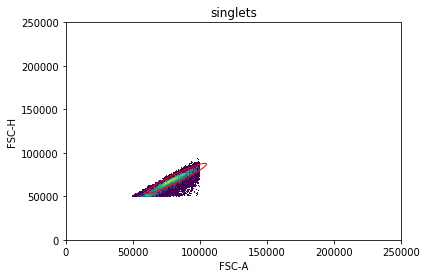

In [788]:
t_template.apply('singlets')

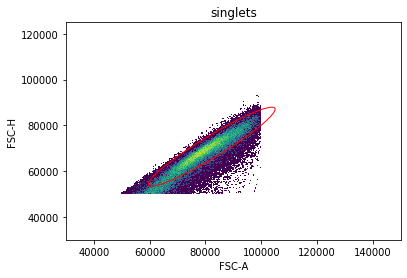

In [789]:
_ = t_template.plot_gate('singlets', xlim=(30000,150000), ylim=(30000,125000))

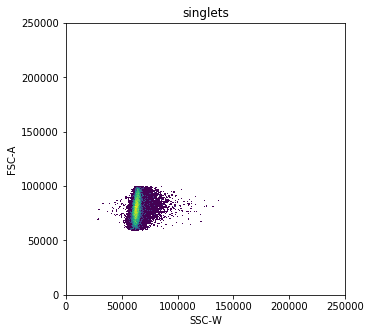

In [790]:
_ = t_template.plot_population('singlets', x='SSC-W', y='FSC-A')

In [791]:
kwargs=dict(q=0.95)
child_populations = dict(singlets_w=dict(definition='-'), doublets=dict(definition='+'))
t_template.create_gate(gate_name='singlets2', parent='singlets', x='SSC-W',
                       func='quantile_gate', func_args=kwargs, gate_type='threshold',
                      child_populations=child_populations)

True

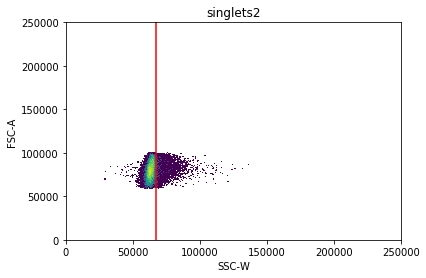

In [792]:
t_template.apply('singlets2')

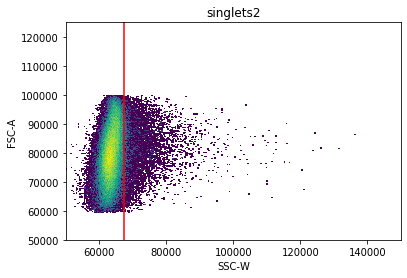

In [793]:
_ = t_template.plot_gate('singlets2', xlim=(50000,150000), ylim=(50000, 125000))

<h3>Live/Dead Gate</h3>

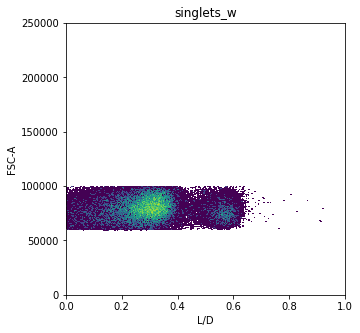

In [794]:
_ = t_template.plot_population('singlets_w', x='L/D', y='FSC-A')

In [795]:
kwargs=dict(q=0.95, kde_bw=0.025, kde_sample_frac=0.5, ignore_double_pos=False, 
            peak_threshold=0.01)
child_populations = dict(dead=dict(definition='+'), live=dict(definition='-'))
t_template.create_gate(gate_name='livedead_gate', parent='singlets_w', x='L/D',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom', child_populations=child_populations)

True

In [796]:
#t_template.remove_gate('livedead_gate')

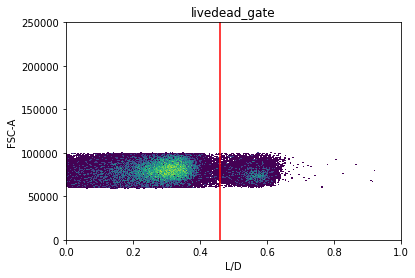

In [797]:
t_template.apply('livedead_gate')

<h3>T Cells (CD3+)</h3>

In [798]:
kwargs=dict(q=0.95, kde_bw=0.1, kde_sample_frac=0.5, ignore_double_pos=True, 
            peak_threshold=0.05)
child_populations = {'cd3+': dict(definition='+'), 'cd3-': dict(definition='-')}
t_template.create_gate(gate_name='cd3_gate', child_populations=child_populations, parent='live', x='CD3',
                       func='density_gate_1d', func_args=kwargs, gate_type='geom')

True

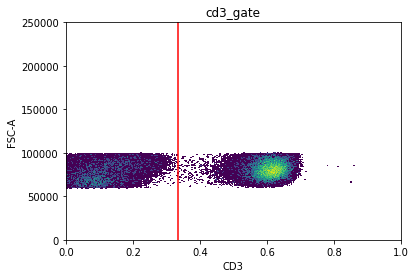

In [799]:
t_template.apply('cd3_gate')

<h3>Gamma Delta T cells</h3>

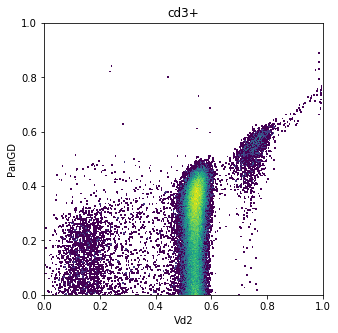

In [800]:
_ = t_template.plot_population('cd3+', x='Vd2', y='PanGD')

In [817]:
kwargs=dict(min_pop_size=5, distance_nn=0.028, core_only=False, nn=15)
child_populations={'gdt': {'target': (0.9, 0.6), 'weight': 0},
                   'non_gdt': {'target': (0.3, 0.1), 'weight': 1}}
t_template.create_gate(gate_name='gdt_gate', child_populations=child_populations, parent='cd3+', x='Vd2',
                       y='PanGD', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

In [816]:
t_template.remove_gate('gdt_gate')

(['gdt', 'non_gdt'], ['gdt_gate'])

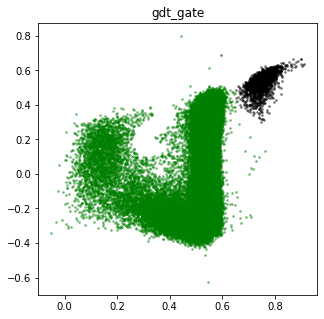

In [818]:
t_template.apply('gdt_gate')

<h3>MAITs</h3>

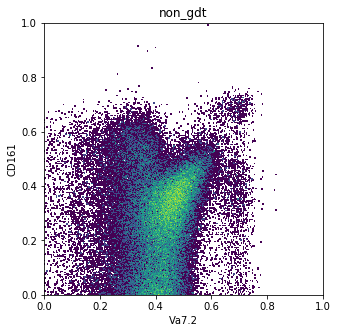

In [819]:
_ = t_template.plot_population('non_gdt', x='Va7.2', y='CD161')

In [820]:
kwargs=dict(min_pop_size=2, distance_nn=0.012, core_only=False)
child_populations={'mait': {'target': (0.9, 0.6), 'weight': 0},
                   'classic_tcells': {'target': (0.2, 0.2), 'weight': 1}}
t_template.create_gate(gate_name='mait_gate', child_populations=child_populations, parent='non_gdt', x='Va7.2',
                       y='CD161', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

In [821]:
#t_template.remove_gate('mait_gate')

Population mait not recognised


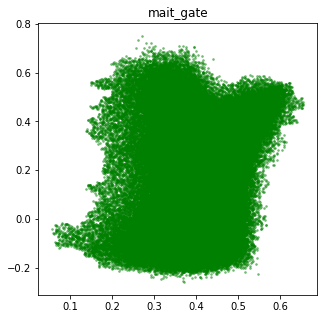

In [822]:
t_template.apply('mait_gate')

<h3>Classic T cells</h3>

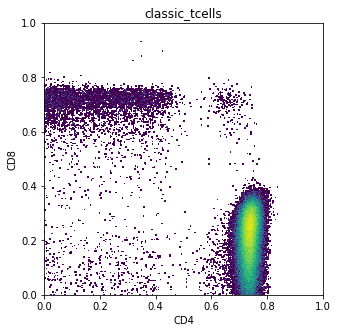

In [823]:
_ = t_template.plot_population('classic_tcells', x='CD4', y='CD8')

In [824]:
kwargs=dict(min_pop_size=3, distance_nn=0.04, core_only=False)
child_populations={'cd4': {'target': (0.8, 0.2), 'weight': 1},
                   'cd8': {'target': (0.2, 0.8), 'weight': 1}}
t_template.create_gate(gate_name='cd4cd8_gate', child_populations=child_populations, parent='classic_tcells', 
                       x='CD4', y='CD8', func='dbscan_gate', func_args=kwargs, gate_type='cluster')

True

In [825]:
#t_template.remove_gate('cd4cd8_gate')

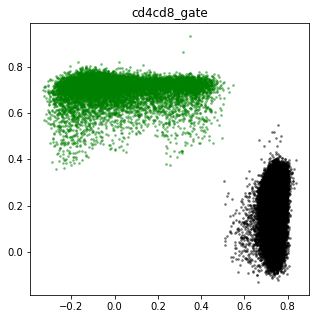

In [826]:
t_template.apply('cd4cd8_gate')

In [827]:
results = []
for name, data in t_template.populations.items():
    results.append(dict(pt_id=t_template.id, name=name, parent=data['parent'], prop_of_parent=data['prop_of_parent'],
                       prop_of_total=data['prop_of_total'], count=len(data['index']))) 

In [828]:
results = pd.DataFrame(results)
all_results = pd.read_csv('experiment_data/auto_results.csv')
all_results = pd.concat([all_results, results])
all_results.to_csv('experiment_data/auto_results.csv', index=False)

In [829]:
t_template.save(overwrite=True)

Saved successfully!


True

In [37]:
#data = t_template.data.copy()
#data.to_csv('experiment_data/data/pd318_10.csv')

In [45]:
t_template.fmo['pd318-01_t_CXCR3'].to_csv('experiment_data/data/pd318_10_CXCR3.csv')

In [37]:
import pickle
with open('experiment_data/data/pd318_10_pops.pickle', 'wb') as f:
    pickle.dump(t_template.populations, f)

<h2>Iterative KNN gating</h2>

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from datetime import datetime
import pickle
import numpy as np

In [44]:
x = pd.DataFrame(np.random.rand(100000, 2), columns=['a', 'b'])

In [45]:
mask = x[x.a > 0.4].index.values

In [48]:
%timeit x.iloc[mask]

1.17 ms ± 80 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
%timeit x[x.index.isin(mask)]

4.39 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
data = pd.read_csv('experiment_data/data/pd318_10.csv')
fmo_data = pd.read_csv('experiment_data/data/pd318_10_CXCR3.csv')
with open('experiment_data/data/pd318_10_pops.pickle', 'rb') as f:
    populations = pickle.load(f)

<h3>Calculate optimal parameters</h3>

In [37]:
features = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W',
            'CXCR3', 'CD161', 'CD3', 'CCR7', 'L/D', 'Va7.2', 'CD8', 'Vd2', 'CD45RA',
            'PanGD', 'CD4', 'CD27']

In [65]:
def get_tree(pop_name, route):
    if pop_name != 'root':
        route.append(pop_name)
        return get_tree(populations[pop_name]['parent'], route)
    return route
def knn_find_population(pop_name, fmo_data):
    tree = get_tree(pop_name, [])[::-1]
    fmo_data = fmo_data.copy()
    data_cache = None
    for p in tree:
        parent = populations[p]['parent']
        if data_cache is not None:
            X = data_cache.loc[populations[parent]['index']].copy()
        else:
            X = data.loc[populations[parent]['index']].copy()
        data_cache = X
        x = populations[p]['geom']['x']
        y = populations[p]['geom']['y']
        if not y:
            y = 'FSC-A'
        pos_idx = populations[p]['index']
        X['pos'] = 0
        X.pos = X.pos.mask(X.index.isin(pos_idx), 1)
        Y = X['pos']
        X = X[[x, y]]
        knn = KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree')
        knn.fit(X, Y)
        y_hat = knn.predict(fmo_data[[x, y]])
        fmo_data['pos'] = y_hat
        fmo_data = fmo_data[fmo_data.pos == 1]
    return fmo_data
    

In [66]:
%%timeit -n 1 -r 1
x = knn_find_population('mait', fmo_data)

5min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Add fmo index caching and plot the results

In [74]:
fmo = {'CXCR3' : {'data': fmo_data, 'index_cache': dict()}}

In [80]:
def population_tree(pop_name, route):
    if pop_name != 'root':
        route.append(pop_name)
        return get_tree(populations[pop_name]['parent'], route)
    return route
def knn_fmo(pop_name, fmo_name):
    # Population has previously been identified for this FMO
    if pop_name in fmo[fmo_name]['index_cache'].keys():
        d = fmo[fmo_name]['data']
        mask = fmo[fmo_name]['index_cache'][pop_name]
        return d.loc[mask]
    # Get population tree
    tree = population_tree(pop_name, [])[::-1]
    # Search FMO cache for existing FMO populations
    start = 0
    for i, p in enumerate(tree):
        if p in fmo[fmo_name]['index_cache'].keys():
            start = i
    if start > 0:
        fmo_data = fmo[fmo_name]['data'].loc[fmo[fmo_name]['index_cache'][tree[start]]].copy()
    else:
        fmo_data = fmo[fmo_name]['data'].copy()
    data_cache = None
    # Iterate over tree and calculate FMO populations
    for p in tree[start:]:
        parent = populations[p]['parent']
        if data_cache is not None:
            X = data_cache.loc[populations[parent]['index']]
        else:
            X = data.loc[populations[parent]['index']].copy()
        data_cache = X
        x = populations[p]['geom']['x']
        y = populations[p]['geom']['y']
        if not y:
            y = 'FSC-A'
        pos_idx = populations[p]['index']
        X['pos'] = 0
        X.pos = X.pos.mask(X.index.isin(pos_idx), 1)
        Y = X['pos']
        X = X[[x, y]]
        knn = KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree')
        knn.fit(X, Y)
        y_hat = knn.predict(fmo_data[[x, y]])
        fmo_data['pos'] = y_hat
        fmo_data = fmo_data[fmo_data.pos == 1]
        fmo[fmo_name]['index_cache'][p] = fmo_data.index.values
    return fmo_data

In [81]:
%%timeit -n 1 -r 1
x = knn_fmo('gdt', 'CXCR3')

6min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [82]:
%%timeit -n 1 -r 1
x = knn_fmo('mait', 'CXCR3')

1.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [83]:
%%timeit -n 1 -r 1
x = knn_fmo('mait', 'CXCR3')

1.58 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
